In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import gc
import math
import time
import pickle
import json
import random
from pathlib import Path 

import numpy as np
import pandas as pd
from IPython.core.debugger import set_trace

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from src.util import *
from src.lr_finder import LRFinder 

In [3]:
set_seed(2020) # make deterministic 

In [4]:
device = 'cuda:0'
# device = 'cpu'

In [5]:
path = Path.cwd()
path.mkdir(exist_ok=True)

In [6]:
data = []
for file in (path/'data'/'encoded').iterdir():
    data.append(file.read_text())

In [7]:
print(data[0][1000:1500]) # show some (encoded) data

L FL FL FL FL L L IL IL IL IL IL IL L L BL BL BL BL BL BL B B BW BW BW BW BW BW     FU FU FU FU FU FU F F FS FS FS FS FS FS     BU BU BU BU BU BU B B BL BL BL BL BL BL     GK GK GK GK GK GK K K FK FK FK FK FK FK     DW DW DW DW DW DW W W BW BW BW BW BW BW W W DW DW DW DW DW DW W W GW GW GW GW GW GW W W AW AW AW AW AW AW A A AU AU AU AU AU AU     DS DS DS DS DS DS D D DR DR DR DR DR DR     IS IS IS IS IS IS I I I# I# I# I# I# I#     BR BR BR BR BR BR BR BR BDR BDR BDR BDR BDR BDR R R BFR BFR BFR 


# Preprocessing

### MIDI Encoding

All the midi files are encoded into strings of ascii characters. Every one of the 88 keys on a keyboard are encoded into an ascii character, in order to make it easier to work with the data (specifically numericalization becomes easier). The 'data' directory already contains an encoded version of the midi files, so now we load the encoding such that we can convert the encoded files into note values and vice versa.

Note that this is the encoding used for turning midi files into strings of ascii characters. The encoding
that will be used later to numericalize the data is different than this one. 

In [8]:
tokens = list(sorted(set(''.join(data))))

In [9]:
with open(path/'encoding.json', 'r') as f:
    note_to_enc = json.load(f)
note_to_enc = {int(k): v for k, v in note_to_enc.items()}
enc_to_note = {v: k for k, v in note_to_enc.items()}

In [10]:
for k, v in note_to_enc.items(): 
    print(f"{k}:{v}", end=' ')  # one item for each of the 88 keys on the piano
len(note_to_enc)

21:0 22:1 23:2 24:3 25:4 26:5 27:6 28:7 29:8 30:9 31:a 32:b 33:c 34:d 35:e 36:f 37:g 38:h 39:i 40:j 41:k 42:l 43:m 44:n 45:o 46:p 47:q 48:r 49:s 50:t 51:u 52:v 53:w 54:x 55:y 56:z 57:A 58:B 59:C 60:D 61:E 62:F 63:G 64:H 65:I 66:J 67:K 68:L 69:M 70:N 71:O 72:P 73:Q 74:R 75:S 76:T 77:U 78:V 79:W 80:X 81:Y 82:Z 83:! 84:# 85:$ 86:% 87:& 88:( 89:) 90:* 91:+ 92:, 93:- 94:. 95:/ 96:: 97:; 98:< 99:= 100:> 101:? 102:@ 103:[ 104:] 105:^ 106:_ 107:` 108:{ 

88

### Data Augmentation

For increasing the effective size of the dataset, we use data augmentation. Specifically, we tranpose each note up one halfstep for each augmentation. We first extend the token set to include the additional tokens that arise due to transposition. The actual data augmentation happens during the training process.

In [14]:
max_transpose = 1  # how many times to tranpose the notes in that dataset

In [15]:
# Add additional tokens not present in the dataset that occur due to music transposition.
highest_note = max(enc_to_note[n] for n in tokens if n != ' ')
tokens.extend([note_to_enc[n] for n in range(highest_note+1, highest_note+max_transpose+1)])

In [16]:
# Note that not all 88 piano keys are used for the music contained in the dataset. This is because 
# Bach's keyboard music was written for harpsichords, which have less than 88 keys. 
print(len(tokens)) 
for c in tokens: print(c, end='')  

68
 !#$%&()*+,-./:ABCDEFGHIJKLMNOPQRSTUVWXYZacdefghijklmnopqrstuvwxyz;<

### Numericalization

Encode the ascii tokens into integers such that they can be fed into the LSTM.

In [17]:
idx_to_enc = dict(enumerate(tokens))
enc_to_idx = {v: k for k, v in idx_to_enc.items()}

In [18]:
data_enc = [np.array([enc_to_idx[ch] for ch in m_str]) for m_str in data]

# Data loading

In [19]:
def get_data(data, max_transpose, seq_len=100, shuffle=True, augmentation=True):
    """ Shuffle and pad the numericalized data and organize it into batches of size seq_len. """
    
    # Padding at end of each piece of music. We do this to more clearly seperate the individual music pieces.
    padding = np.array(30 * [enc_to_idx[' ']])
    data = [np.concatenate([seq, padding]) for seq in data]
    
    if shuffle: 
        data = np.random.permutation(data)
    
    if augmentation:
        data_trnsp = []
        for steps in range(max_transpose + 1):       
            for i, song in enumerate(data):
                mask = steps * (data[i] != 0) 
                data_trnsp.append(data[i] + mask)
        data = data_trnsp
    
    data = np.concatenate(data)
    X = np.array([data[i*seq_len:(i+1)*seq_len] for i in range(len(data) // seq_len)])
    Y = np.zeros_like(X)
    Y[:, :-1] = X[:, 1:]
    Y[:-1, -1] = X[1:, 0]
    return X, Y

In [21]:
# Create train/eval split from the data.
random.shuffle(data_enc)
eval_idx = math.ceil(0.8 * len(data_enc))
data_train = data_enc[:eval_idx]
data_eval = data_enc[eval_idx:]

In [22]:
len(data_train), len(data_eval)  # number of songs per dataset

(115, 28)

# Model

We use a character level LSTM, which takes as input a single encoded note, and outputs a probability 
distribution over the range of possible notes. The way we then sample from the trained LSTM goes as follows. 
We use top_k sampling to pick a note from the output distribution of the LSTM. This note is then fed
back into the network, which can consequently be used to predict the note after that. This way we can
sample from the LSTM indefinitely.

In [23]:
class CharLSTM(nn.Module):
    def __init__(self, hidden_dim, wordvec_dim, vocab_size, n_layers=2, bidirectional=False, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.wordvec_dim = wordvec_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.n_directions = 2 if bidirectional else 1
        
        self.emb = nn.Embedding(vocab_size, wordvec_dim)
        self.lstm = nn.LSTM(wordvec_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, hc):
        emb = self.emb(x)
        hs, hc_n = self.lstm(emb, hc)
        hs = self.dropout(hs)
        logits = self.fc(hs).squeeze()
        return logits, hc_n

In [95]:
n_layers = 2
hidden_dim = 512
wordvec_dim = 512
net = CharLSTM(hidden_dim, wordvec_dim, len(tokens), n_layers)
net.to(device)

CharLSTM(
  (emb): Embedding(68, 512)
  (lstm): LSTM(512, 512, num_layers=2, batch_first=True)
  (fc): Linear(in_features=512, out_features=68, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [96]:
count_parameters(net)

4272196

In [97]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [104]:
epochs = 9

In [105]:
train_sample = get_data(data_train, max_transpose)

In [106]:
batches_per_epoch = train_sample[0].shape[0]

In [107]:
scheduler = None

In [108]:
lr_finder = LRFinder(net, optimizer, criterion, scheduler)
lst_data_X, lst_data_Y = [list(dat) for dat in train_sample]
lr_finder.lr_find_lstm(zip(lst_data_X, lst_data_Y), bs=1, num_it=200, device=device)

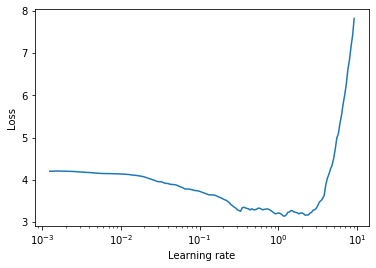

In [109]:
lr_finder.plot()

In [110]:
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=2e-1, 
    steps_per_epoch=train_sample[0].reshape(-1).shape[0], 
    epochs=epochs
)

In [111]:
def loss_batch(net, criterion, xb, yb, hc, optimizer=None, scheduler=None, grad_clip=5):
    logits, (h_next, c_next) = net(xb, hc)
    loss = criterion(logits, yb)
    n_correct = (torch.max(logits, dim=1)[1] == yb).sum().item()

    if optimizer is not None:
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(), grad_clip)  # clip gradients to avoid exploding gradients
        optimizer.step()
        
        if scheduler is not None:
            scheduler.step()
    return loss.item(), h_next, c_next, xb.squeeze().shape[0], n_correct

In [112]:
def train(epochs, grad_clip=5, plot_every=100, checkpoint_dir=None):
    h_next, c_next = init_hidden_and_cell_state(net.n_layers, net.hidden_dim)
    h_next, c_next = h_next.to(device), c_next.to(device)
    
    plot_losses_train, plot_losses_eval = [], []
    for ep in range(epochs):
        running_loss, n_correct, n_samples, plot_loss_total = 0, 0, 0, 0
        start_t = time.time()
        
        X, Y = get_data(data_train, max_transpose)
        for i in range(X.shape[0]):
            net.train()

            xb, yb = torch.from_numpy(X[i]).unsqueeze(0), torch.from_numpy(Y[i])
            xb, yb = xb.to(device), yb.to(device)
            
            loss, h_next, c_next, _, _  = loss_batch(net, criterion, xb, yb, (h_next, c_next), optimizer, scheduler) 
            running_loss += loss
            plot_loss_total += loss
            
            # After forward pass: requires_grad = True for h and c. Reset this.
            (h_next, c_next) = tuple(a.data for a in (h_next, c_next))
            
            if i % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses_train.append(plot_loss_avg)
                plot_loss_total = 0
            
        time_elapsed = time_since(start_t)  # type=str
        train_loss = running_loss / X.shape[0]
        
        net.eval()
        h_next, c_next = init_hidden_and_cell_state(net.n_layers, net.hidden_dim)
        h_next, c_next = h_next.to(device), c_next.to(device)
        losses, nums, correct = [], [], []
        with torch.no_grad():
            X, Y = get_data(data_eval, max_transpose, shuffle=False, augmentation=False)
            for i in range(X.shape[0]):
                xb, yb = torch.from_numpy(X[i]).unsqueeze(0), torch.from_numpy(Y[i])
                loss, h_next, c_next, n, cor = \
                    loss_batch(net, criterion, xb.to(device), yb.to(device), (h_next, c_next))
                (h_next, c_next) = tuple(a.data for a in (h_next, c_next))
                losses.append(loss)
                nums.append(n)
                correct.append(cor)
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        val_acc = np.sum(correct) / np.sum(nums)
        print("Epoch {}. train_loss: {:.4f}. val_loss: {:.4f}. val_acc: {:.4f}. {}s"
              .format(ep, train_loss, val_loss, val_acc, time_elapsed))
        plot_losses_eval.append(val_loss)
        
        if checkpoint_dir is not None:
            Path(checkpoint_dir).mkdir(exist_ok=True, parents=True)
            cn = checkpoint_dir/"{}_epoch{}_{:.6f}.net".format(type(net).__name__, ep, val_loss)
            save_checkpoint(net, cn)
        start_t = time.time()
    show_plot(plot_losses_train, plot_losses_eval, plot_every, batches_per_epoch)

In [113]:
@torch.no_grad()
def sample(seed_chars, seq_len, top_k=5):
    """
    Sample output from the network, given an initial seed_idx.
    
    Input:
    seed_chars: string of seed character(s) to initialize the network with.
    seq_len: number of characters to sample from the network.
    
    """
    h_next, c_next = init_hidden_and_cell_state(net.n_layers, net.hidden_dim)
    h_next, c_next = h_next.to(device), c_next.to(device)
    hc = (h_next, c_next)
    
    seed_idx = [enc_to_idx[c] for c in seed_chars]
    idxs = seed_idx[:]
    seed_idx = torch.LongTensor(seed_idx).view(1, -1)
    seed_idx = seed_idx.to(device)
    
    net.eval()
    
    # 'warm up' the hidden and cell state by runnning the seed characters through the network.
    scores, hc = net(seed_idx, hc)
        
    # Sample characters, feeding the highest scoring character back into the network.
    scores = scores[-1, :]#.view(1, 1, -1)
    for i in range(seq_len):
        ps = F.softmax(scores, dim=0).data.cpu()
        ps, top_idx = ps.topk(top_k)
        
        top_idx = top_idx.numpy().squeeze()
        ps = ps.numpy().squeeze()
        
        next_idx = np.random.choice(top_idx, p=ps/ps.sum())
        idxs.append(next_idx)
        next_idx = torch.LongTensor([next_idx]).to(device).view(1, -1)
       
        scores, hc = net(next_idx, hc)
    return ''.join([idx_to_enc[idx] for idx in idxs])

Epoch 0. train_loss: 0.7615. val_loss: 0.8132. val_acc: 0.8213. 5:14s
Epoch 1. train_loss: 0.5067. val_loss: 0.7885. val_acc: 0.7913. 5:11s
Epoch 2. train_loss: 0.4399. val_loss: 0.5923. val_acc: 0.8509. 5:16s
Epoch 3. train_loss: 0.4019. val_loss: 0.5726. val_acc: 0.8626. 5:9s
Epoch 4. train_loss: 0.3771. val_loss: 0.5454. val_acc: 0.8684. 5:10s
Epoch 5. train_loss: 0.3562. val_loss: 0.5391. val_acc: 0.8608. 5:11s
Epoch 6. train_loss: 0.3456. val_loss: 0.5101. val_acc: 0.8711. 5:12s
Epoch 7. train_loss: 0.3270. val_loss: 0.5293. val_acc: 0.8664. 5:12s
Epoch 8. train_loss: 0.3124. val_loss: 0.5183. val_acc: 0.8666. 5:13s


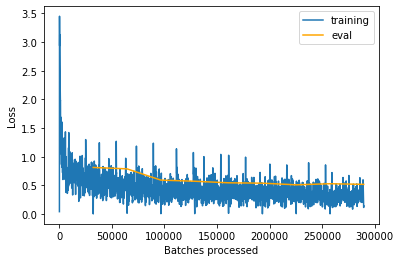

In [114]:
train(epochs)

## Results

Now that we've trained our model, let's sample some predictions. Note that the output of the LSTM is still encoded, so we have to use `deprocess.py` and `csvtomidi.py` in order to turn the sample into a MIDI file.

In [115]:
sample('  ', 200)  # result is still encoded

'                                   u u u u u u u u u u u u u u u u u u u u u       z z z z z z z z z z z z z z z z s s s s s q q q r r s s u u u u s s s s s s s s s s s s s u u u u u u u v v v v v v v v'

In [106]:
# Start with a neutral seed: a few silent notes.
seed = '   '
out = sample(seed, 30000, top_k=10)  # sequence of length 100 is +- 1 sec of music
(path/'out1.txt').write_text(out);

In [103]:
# Initialize the network with the first 7 seconds of Contrapunctus I of the Art of Fugue.
seed = 'F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E F F F F F F F F F F F F F F F F H H H H H H H H H H H H H H H H I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I K K K K K K K K I I I I I I I I H H H H H H H H FM FM FM FM FM FM FM FM FM FM FM FM FM FM FM FM'
out = sample(seed, 30000, top_k=10)  # sequence of length 100 is +- 1 sec of music
(path/'out2.txt').write_text(out);

In [ ]:
# Turn the output into a MIDI file.
!python deprocess.py -i out1.txt -o tmp.txt --tempo 250000
!python csvtomidi.py -i tmp.txt -o out1.mid